In [1]:
##Importing all needed libraries
try:
    # Summit-related imports
    import summit
    from summit.benchmarks import ExperimentalEmulator
    from summit.domain import *
    from summit.utils.dataset import DataSet
    from summit.strategies import SOBO, MultitoSingleObjective, LHS

    # External libraries
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # File and path handling
    import pathlib
    import os

except ModuleNotFoundError as e:
    print(f"Error: {e}. Please install the required libraries before running the program.")


In [2]:
# Configurable parameters
base_path = pathlib.Path("D:\!PythonCode\MLModelTest")
PROJECT_NAME = "ColinKinetic"
BOUNDS_NAME = f"{PROJECT_NAME}_Bounds.csv"
DATA_NAME = f"{PROJECT_NAME}_Data.csv"
LOG_NAME = f"{PROJECT_NAME}_Log.csv"

# Folder Name
DATA_DIR = "Data"
MODEL_DIR = "Models"
IT_DIR = "IterData"
LOG_DIR = "Logs"

# Function to create directory if it doesn't exist
def create_directory(base_path, directory):
    """Create a directory if it doesn't exist."""
    dir_path = base_path / directory
    if not dir_path.is_dir():
        dir_path.mkdir(parents=True)
        
# Create directories
for directory in [DATA_DIR, MODEL_DIR, IT_DIR, LOG_DIR]:
    create_directory(base_path, directory)

# Set data paths
data_path = base_path / DATA_DIR
model_path = base_path / MODEL_DIR
it_path = base_path / IT_DIR
log_path = base_path / LOG_DIR


# Load initial boundaries data
try:
    init_bounds_df = pd.read_csv(data_path / BOUNDS_NAME)
except FileNotFoundError:
    print(f"Error: File '{BOUNDS_NAME}' not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print(f"Error: File '{BOUNDS_NAME}' is empty or in an invalid format.")


In [3]:
def create_domain(init_bounds_df):
    """
    Create a Summit domain based on the provided boundaries DataFrame.

    Parameters:
    - init_bounds_df (pd.DataFrame): DataFrame containing information about variable boundaries.

    Returns:
    - domain (Domain): The created Summit domain.
    - obj_df (pd.DataFrame): DataFrame for objective variables.
    - in_count (int): Count of input variables.
    - out_count (int): Count of output variables.
    """
    if not isinstance(init_bounds_df, pd.DataFrame) or init_bounds_df.empty:
        raise ValueError("Invalid input: init_bounds_df must be a non-empty DataFrame.")
        
    domain = Domain()
    obj_df = pd.DataFrame()
    obj_df = DataSet.from_df(obj_df)

    in_count = 0
    out_count = 0

    for idx, row in init_bounds_df.iterrows():
        name = row[0]
        description = row[5]
        data_type = row[1]

        if data_type == 'Categorical':
            levels = row[2].split(',')

            domain += CategoricalVariable(
                name = name,
                description = description,
                levels = levels
            )
            in_count += 1

        elif data_type == 'Continuous':
            bounds = [row[3], row[4]]

            domain += ContinuousVariable(
                name = name,
                description = description,
                bounds = bounds
            )
            in_count += 1

        elif data_type == 'Objective':
            bounds = [row[3], row[4]]
            maximize = row[6]

            domain += ContinuousVariable(
                name = name,
                description = description,
                bounds = bounds,
                is_objective = True,
                maximize = maximize
            )
            out_count += 1

            obj_df[(name, "DATA")] = ""
        
    return domain, obj_df, in_count, out_count


In [8]:
data_df = DataSet.read_csv(data_path / DATA_NAME) 
domain, obj_df, in_count, out_count = create_domain(init_bounds_df)

In [9]:
data_df

,Temperature,VP_IPA,H2SO4,RT,HBA,Sulfonate,Mono,isopropxy,hydroxybenzoate,DIPBA,monoest,esterified,tri,pseudo
,DATA,DATA,DATA,DATA,DATA,DATA,DATA,DATA,DATA,DATA,DATA,DATA,DATA,DATA
0,70.0,97.0,15.0,2.0,91.00,0.20,2.00,0.70,2.20,3.00,0.70,0.10,0.00,0.00
1,70.0,97.0,15.0,3.0,90.70,0.20,1.80,0.90,2.60,2.90,0.70,0.10,0.00,0.00
2,70.0,97.0,15.0,5.0,84.10,0.30,2.50,1.50,4.50,3.80,2.90,0.30,0.00,0.00
3,70.0,97.0,15.0,7.5,79.70,0.20,3.00,2.60,7.60,3.50,2.50,0.80,0.00,0.00
4,70.0,97.0,15.0,10.0,62.70,0.20,4.00,6.80,16.10,3.40,3.40,2.20,0.50,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,86.0,100.0,38.0,5.0,7.09,3.59,19.05,1.68,3.20,42.26,8.05,11.31,1.56,0.00
64,86.0,100.0,38.0,7.5,0.32,4.57,5.99,1.07,0.07,54.25,0.81,10.64,4.15,0.68
65,86.0,100.0,38.0,10.0,0.00,4.85,3.18,0.60,0.59,52.10,0.10,6.94,6.31,1.43


In [6]:
domain

Name,Type,Description,Values
Temperature,"continuous, input",nan,"[70,89]"
VP_IPA,"continuous, input",nan,"[85,100]"
H2SO4,"continuous, input",nan,"[15,38]"
RT,"continuous, input",nan,"[2,20]"
HBA,"continuous, minimize objective",nan,"[0,1]"
Sulfonate,"continuous, minimize objective",nan,"[0,1]"
Mono,"continuous, minimize objective",nan,"[0,1]"
isopropxy,"continuous, minimize objective",nan,"[0,1]"
hydroxybenzoate,"continuous, maximize objective",nan,"[0,1]"
DIPBA,"continuous, minimize objective",nan,"[0,1]"


{'test_r2': array([0.76025096, 0.77724599, 0.77720006, 0.76370731, 0.88054967]),
 'test_neg_root_mean_squared_error': array([-2.30261187, -2.83135074, -2.35307632, -2.68043499, -1.81242429])}

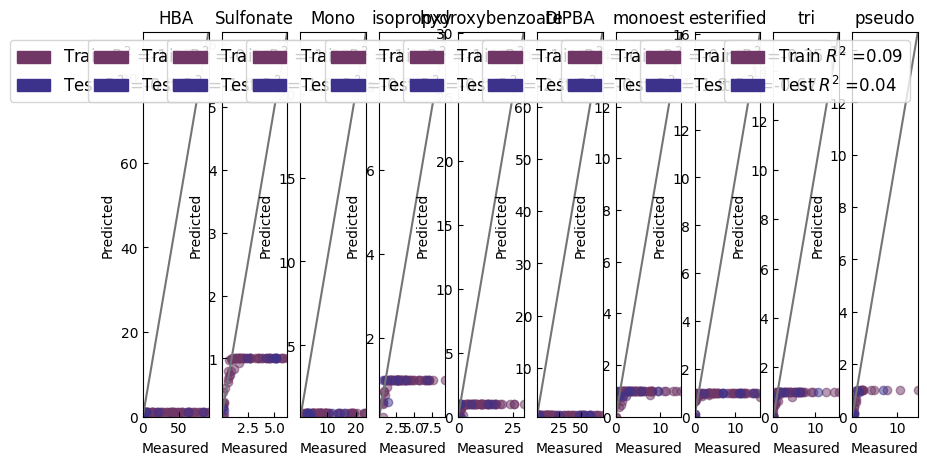

In [11]:
test_size = 0.1
exp_num = 68
cv_fold = 61

emul = ExperimentalEmulator(
    model_name = PROJECT_NAME,
    domain = domain,
    dataset = data_df
)

emul.train(
    max_epochs = 10000,
    cv_fold = cv_fold,
    random_state = 808,
    test_size = test_size,
    verbose = 0,
)

fig, ax = emul.parity_plot(include_test=True)
scores = emul.test()
scores

In [13]:
import numpy as np
import os
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import pandas as pd

data = pd.read_csv(r'D:\!PythonCode\ChemistryOptimization\DataSets\PropMeltCrystal\Data\Data\95_5_PropMeltCrystal_Data_Fin.csv')

# Extract the input features (X) and target variable (y)
X = data.iloc[:, :-2].values
y = data.iloc[:, -2:].values

# Scale the input features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Scale the target variables
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Create an instance of the ANN model with 2 output neurons
ann_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000)

# Define the number of folds for k-fold cross-validation
n_folds = 5

# Create an instance of the k-fold cross-validator
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation on the ANN model
scores_output_1 = []
scores_output_2 = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]
    ann_model.fit(X_train, y_train)
    
    # Predictions for the entire test set
    y_pred = ann_model.predict(X_test)
    
    # Score for output 1
    score_output_1 = r2_score(y_test[:, 0], y_pred[:, 0])
    scores_output_1.append(score_output_1)
    
    # Score for output 2
    score_output_2 = r2_score(y_test[:, 1], y_pred[:, 1])
    scores_output_2.append(score_output_2)

# Print the mean and standard deviation of the scores for each output
print(f"Mean score for output 1: {np.mean(scores_output_1):.2f}")
print(f"Standard deviation for output 1: {np.std(scores_output_1):.2f}")

print(f"Mean score for output 2: {np.mean(scores_output_2):.2f}")
print(f"Standard deviation for output 2: {np.std(scores_output_2):.2f}")

Mean score for output 1: 0.18
Standard deviation for output 1: 0.99
Mean score for output 2: 0.04
Standard deviation for output 2: 0.54
